---

<center>

# **12 Steps to Navier-Stokes**

<center>

---


## Step 10: 2D Poisson's Equation

---

Before we start with **Poisson's equation**, recall **where we are heading, the Navier-Stokes equations** for an incompressible fluid, where $\vec{v}$ represents the **velocity field**


$$\nabla \cdot\vec{v} = 0$$ 
$$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v} = -\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}$$

Mass conservation at constant density is ensured by the first equation, then conservation of momentum is defined by the second equation.

Everything is pretty untill we realize there is no way to know how the pressure changes with time, look the continuity equation for compressible fluids

$$\frac{\partial\rho}{\partial t}+\nabla\cdot(\rho\vec{v})=0$$

here the evolution of the density is known and an equation of state can gave us a way to solve for pressure.

A way out of this difficulty is to **construct a pressure field that guarantees the continuity equation is satisfied**, to do so we do the following:

1. The momentum equation
$$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v} = -\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}$$

2. Take the divergence at both sides
$$\nabla\cdot\left(\frac{\partial\vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v}\right)=\nabla\cdot\left(-\frac{1}{\rho}\nabla p+\nu\nabla^2\vec{v}\right)$$

3. Simplify
$$\nabla\cdot((\vec{v}\cdot\nabla)\vec{v})=-\frac{1}{\rho}\nabla^2p$$

4. Rearrange
$$\nabla^{2}p=-\rho\nabla\cdot((\vec{v}\cdot\nabla)\vec{v})$$

This last expression is Poisson's equation for pressure with a source term ($-\rho\nabla\cdot((\vec{v}\cdot\nabla)\vec{v})$), replace the source term with $b$ and we have

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$

We will solve this equation by assuming an initial state of $p=0$ everywhere, and applying boundary conditions as follows:

$$p=0 \hspace{5mm}at\hspace{5mm} x=0, \ 2 \hspace{5mm}and\hspace{5mm} y=0, \ 1$$

and the source term consists of **two initial spikes inside the domain**, as follows:

$$b_{i,j}=100 \hspace{5mm}at\hspace{5mm} i=\frac{1}{4}nx, j=\frac{1}{4}ny$$

$$b_{i,j}=-50 \hspace{5mm}at\hspace{5mm} i=\frac{3}{4}nx, j=\frac{3}{4}ny$$

$$b_{i,j}=0\hspace{5mm}everywhere\hspace{1mm}else.$$ 

The iterations will advance in pseudo-time to relax the initial spikes untill the L1 norm target is reached.

**Poisson's equations acts to "relax" the initial sources in the field**. In discretized form, this looks almost the same as [Step 9](./Step_9.ipynb), except for the source term:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2 p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2}=b_{i,j}^{n}$$

As before, **we rearrange** this so that we obtain an equation for $p$ at point $i,j$. **Thus, we obtain**:

$$p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2-b_{i,j}^{n}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$


Coding time

In [1]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.ticker import FormatStrFormatter

Plotting function, reused

In [40]:
def plot_p_2d(x, y, p):
    """
    
    a
    
    """

    X, Y = np.meshgrid(x, y)

    fig, axis = plt.subplots(subplot_kw={"projection":"3d"}, dpi=100, figsize= (11, 7))
    surf = axis.plot_surface(X, Y, p[:], cmap='viridis', linewidth=0.1)
    axis.set_title(r"Pressure field with sources and sink", fontsize=15)
    axis.set_xlim(0, 2)
    axis.set_ylim(0, 2)
    # axis.set_zlim(-50, 100)
    axis.set_ylabel('$y$', fontsize=12)
    axis.set_xlabel('$x$', fontsize=12)
    axis.set_zlabel('$p$', fontsize=12)
    axis.view_init(elev=25, azim=240)
    axis.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar = plt.colorbar(surf, pad=0.075, shrink=0.75)
    cbar.set_label('Pressure ($p$)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    # cbar.set_ticks([0, 0.5, 1, 1.5, 1.9,])
    plt.tight_layout()
    plt.show()
      

Solver function, sort of reused

In [41]:
def poisson_solver_2d(p, x, y, b, dx, dy, l1_norm_target):
    """
    
    a
    
    """

    l1_norm = 1
    p_n = p.copy()

    while l1_norm > l1_norm_target:
        p_n = p.copy()
        p[1:-1, 1:-1] = (((dy**2) * (p[1:-1, 2:] + p[1:-1, :-2])) + ((dx**2) * (p[2:, 1:-1] + p[:-2, 1:-1])) - (b[1:-1, 1:-1] * (dx**2) * (dy**2))) / (2 * ((dx**2) + (dy**2)))

        l1_norm = (np.sum(np.abs(p[:] - p_n[:]))) / (np.sum(np.abs(p_n[:])) + 0.0000001)

    return p

Then, defining parameters, IC's for the source term and BC's for the pressure field

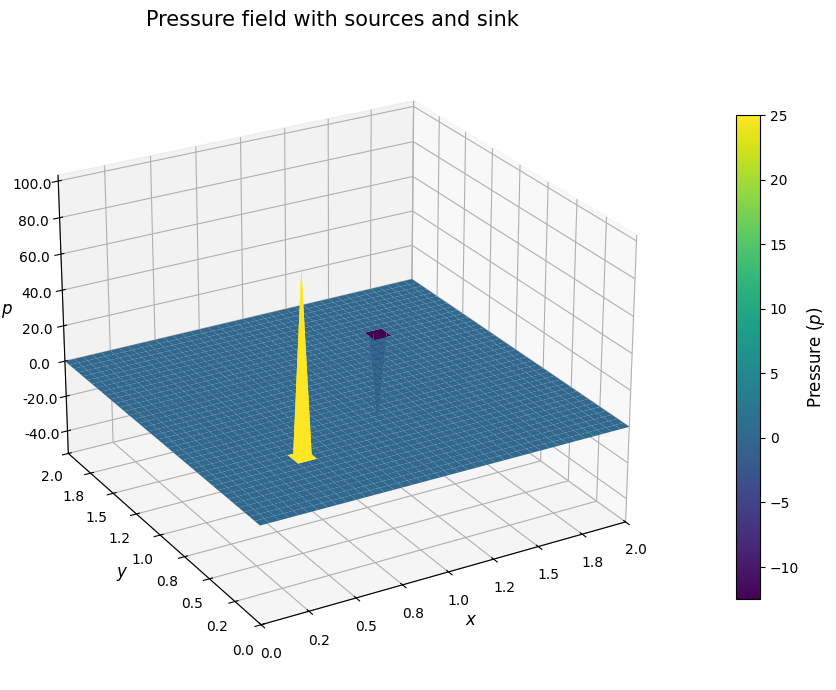

In [43]:
x_points = 41                                 # Number of x grid points
y_points = 41                                 # Number of y grid points
grid_length = 2                               # Lenght of the grid
dx = grid_length / (x_points - 1)             # Distance between adjacent x grid points
dy = grid_length / (x_points - 1)             # Distance between adjacent y grid points

p = np.zeros((y_points, x_points))
b = np.zeros((y_points, x_points))
x = np.linspace(0, grid_length, x_points)
y = np.linspace(0, grid_length, y_points)

p[:, 0] = 0
p[:, -1] = 0
p[0, :] = 0
p[-1, :] = 0

b[int((1/4)* y_points), int((1/4)* x_points)]  = 100
b[int((3/4) * y_points), int((3/4) * x_points)] = -50

plot_p_2d(x, y, b)

Now using the solver and plotting

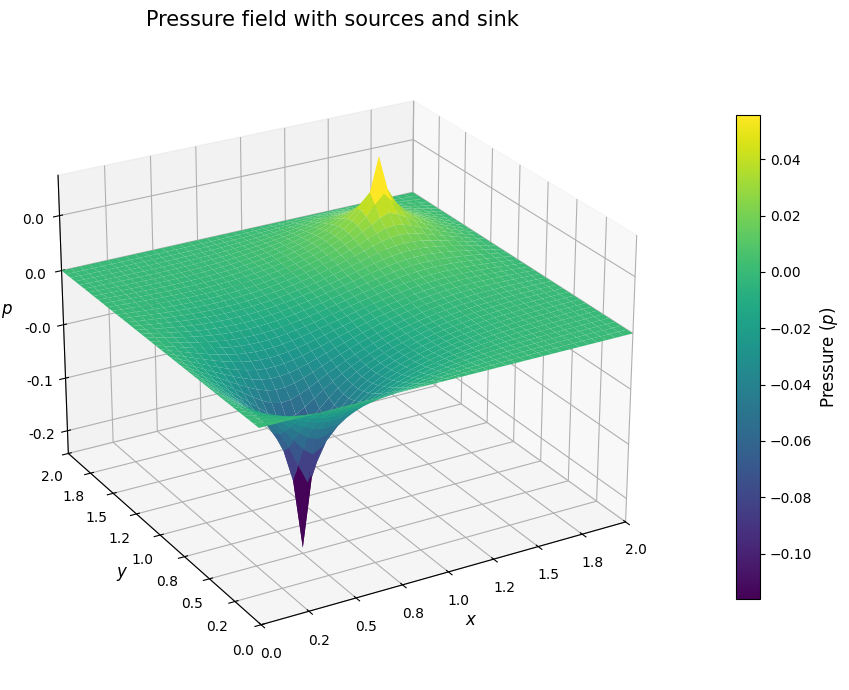

In [44]:
p = poisson_solver_2d(p, x, y, b, dx, dy, 1e-4)

plot_p_2d(x, y, p)

We see an snapshot of the relaxation of the spikes. For the animation I'll reuse the code from Step 8 and for the solver here use a `for` loop with pseudo-time with no L1 norm for convergence

In [46]:
x_points = 41                                 # Number of x grid points
y_points = 41                                 # Number of y grid points
grid_length = 2                               # Lenght of the grid
dx = grid_length / (x_points - 1)             # Distance between adjacent x grid points
dy = grid_length / (x_points - 1)             # Distance between adjacent y grid points
time_steps = 275

p = np.zeros((y_points, x_points))
p_n = p.copy()
b = np.zeros((y_points, x_points))

x = np.linspace(0, grid_length, x_points)
y = np.linspace(0, grid_length, y_points)
X, Y = np.meshgrid(x, y)

p[:, 0] = 0
p[:, -1] = 0
p[0, :] = 0
p[-1, :] = 0

b[int((1/4)* y_points), int((1/4)* x_points)]  = 100
b[int((3/4) * y_points), int((3/4) * x_points)] = -50

plt.ioff()
fig, axis = plt.subplots(subplot_kw={"projection": "3d"}, dpi=100, figsize=(11, 7))
axis.set_title("2D Poisson's Equation")
axis.set_xlim(0, 2)
axis.set_ylim(0, 2)
# axis.set_zlim(-50, 100)
axis.set_ylabel('y')
axis.set_xlabel('x')
axis.set_zlabel('u')
axis.view_init(elev=30, azim=-30)
axis.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axis.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

surf = axis.plot_surface(X, Y, p[:], cmap='viridis', linewidth=0)
plt.colorbar(surf, ax=axis, pad=0.12, shrink=0.8)


def init():
    axis.clear()
    axis.set_title("2D Poisson's Equation")
    axis.set_xlim(0, 2)
    axis.set_ylim(0, 2)
    # axis.set_zlim(-50, 100)
    axis.set_ylabel('y')
    axis.set_xlabel('x')
    axis.set_zlabel('u')
    axis.view_init(elev=30, azim=-30)
    axis.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    surf = axis.plot_surface(X, Y, p[:], cmap='viridis', linewidth=0)
    return surf,

def update_anim(frame):
    p_n = p.copy()

    p[1:-1, 1:-1] = ((((dy**2) * (p[1:-1, 2:] + p[1:-1, :-2])) 
                     + ((dx**2) * (p[2:, 1:-1] + p[:-2, 1:-1])) 
                     - (b[1:-1, 1:-1] * (dx**2) * (dy**2))) 
                     / (2 * ((dx**2) + (dy**2))))

    p[0, :] = 0
    p[y_points-1, :] = 0
    p[:, 0] = 0
    p[:, x_points-1] = 0

    axis.clear()
    axis.set_title("2D Poisson's Equation")
    axis.set_xlim(0, 2)
    axis.set_ylim(0, 2)
    # axis.set_zlim(-50, 100)
    axis.set_ylabel('y')
    axis.set_xlabel('x')
    axis.set_zlabel('u')
    axis.view_init(elev=30, azim=-30)
    axis.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    surf = axis.plot_surface(X, Y, p[:], cmap='viridis', linewidth=0)
    return surf,


anim = animation.FuncAnimation(
                fig = fig,
                func = update_anim,
                init_func = init,
                frames = time_steps,
                interval = 50
)

anim.save('2D_Poisson_equation.mp4', writer=animation.FFMpegWriter(fps=30))

plt.ion()